In [1]:
pip install pandas numpy scikit-learn matplotlib yfinance tensorflow scikeras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor

In [3]:
# Download Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")

# Calculate moving averages and relative price change
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# set target as percentage difference from future days
PREDICTED_DAYS = 1
for i in range(1, PREDICTED_DAYS + 1):
    data[f'target_{i}'] = -data['Close'].shift(-1)

# Drop rows with missing values
data.dropna(inplace=True)

#print(data)

[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2015-03-16   27.935474   31.237499   31.237499   30.717501   30.969999   
2015-03-17   28.402746   31.760000   31.830000   31.412500   31.475000   
2015-03-18   28.722456   32.117500   32.290001   31.592501   31.750000   
2015-03-19   28.505587   31.875000   32.312500   31.850000   32.187500   
2015-03-20   28.147873   31.475000   32.099998   31.290001   32.062500   
...                ...         ...         ...         ...         ...   
2022-12-22  130.853958  132.229996  134.559998  130.300003  134.350006   
2022-12-23  130.487793  131.860001  132.419998  129.639999  130.919998   
2022-12-27  128.676849  130.029999  131.410004  128.720001  131.380005   
2022-12-28  124.728371  126.040001  131.029999  125.870003  129.669998   
2022-12-29  128.261215  129.610001  13

In [17]:
#scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = data[['SMA_10', 'SMA_50', 'High', 'Close', 'Open', 'Low']]
X_scaled = scaler_X.fit_transform(X)

y = data[[f'target_{i}' for i in range(1, PREDICTED_DAYS + 1)]]
y_scaled = scaler_y.fit_transform(y)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

In [5]:
#repeatable way to create the model 
def create_ann(neurons=32, activation='relu', optimizer='admin'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  #input structure
    model.add(Dense(neurons, activation=activation)) # hidden layer
    model.add(Dense(PREDICTED_DAYS)) #output
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

<h1> GridSearch setup </h1>

In [6]:
# defone model parameters and create model
param_grid = {
    'model__neurons': [16, 32, 64, 128],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [7]:
#training
model = KerasRegressor(model=create_ann, verbose=0) #keras regressor is a wrapper to us scikit learn gid search


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_absolute_error',         # Use mse as scoring
    verbose=100,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\kenan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [8]:
# results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
# for i, row in results_df.iterrows():
#     print(f"Rank {row['rank_test_score']}:")
#     print(f"Parameters: {row['params']}")
#     print(f"Mean Test Score: {row['mean_test_score']:.4f}")
#     print(f"Std Dev of Test Score: {row['std_test_score']:.4f}")
#     print("-" * 30)

In [9]:
def graph_predictions(predictions, actual, title):
    # Visualize Predictions vs. Actual Outcomes
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predictions, alpha=0.7, color='b', label='Predicted vs Actual')
    plt.plot([predictions.min(), predictions.max()], [predictions.min(), predictions.max()], 'r--', lw=2, label='Perfect Prediction')  # Diagonal line
    plt.title(f'{title}: Actual vs Predicted Values', fontsize=14)
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    mae = mean_absolute_error(predictions, actual)
    mse = mean_squared_error(predictions, actual)
    rmse = np.sqrt(mse)

    print(f"{title}  MAE: {mae}")
    print(f"{title}  RMSE: {rmse}")

    # trueUp = 0 #predicted up actual up
    # trueDown = 0 #predicted down actual down
    # falseUp = 0 #prdicted up actual down
    # falseDown = 0 #predicted down actual up
    # for i in range(len(predictions)):
    #     if(predictions[i] <= 0 and actual[i] < 0):
    #         trueUp +=1
    #     elif(predictions[i] <= 0 and actual[i] > 0):
    #         falseUp +=1
    #     elif(actual[i] < 0):
    #         trueDown +=1
    #     else:
    #         falseDown +=1

    # confusion_matrix = np.array([[trueUp, falseDown], 
    #                          [falseUp, trueDown]])

    # # Labels for the axes
    # categories = ["Actual Up", "Actual Down"]
    # predictions = ["Predicted Up", "Predicted Down"]
    
    # # Plot the confusion matrix
    # plt.figure(figsize=(6, 6))
    # sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=predictions, yticklabels=categories)
    # plt.xlabel("Predicted Labels", fontsize=12)
    # plt.ylabel("Actual Labels", fontsize=12)
    # plt.title("Confusion Matrix", fontsize=14)
    # plt.show()


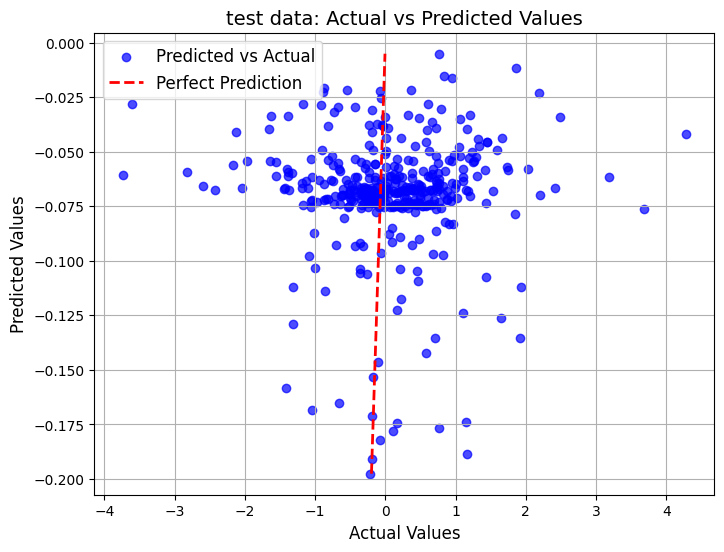

test data  MAE: 0.6728259357617484
test data  RMSE: 0.9270796208405712


In [10]:
# use best model to predict test data=
predictions = grid_search.best_estimator_.predict(X_test)
graph_predictions(predictions, y_test, "test data")


[*********************100%***********************]  1 of 1 completed


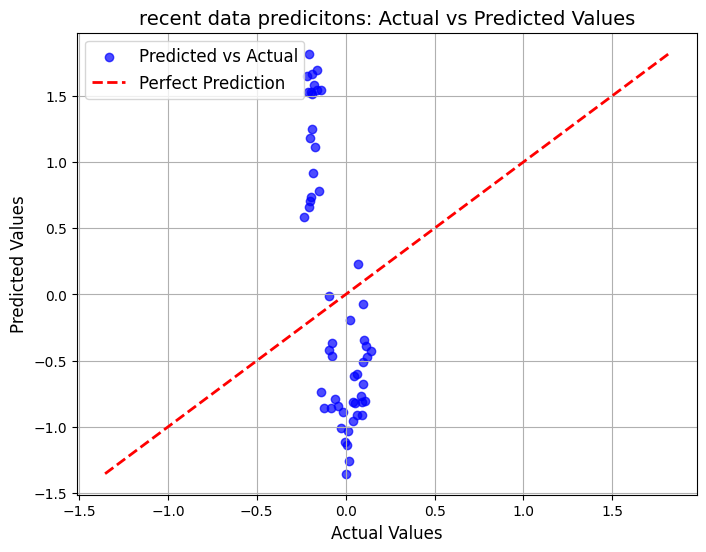

recent data predicitons  MAE: 0.9776991268737918
recent data predicitons  RMSE: 1.0945456088489394


In [11]:
# trying to predict more recent ones
stock = yf.Ticker('AAPL')
data_to_predict = yf.download("AAPL", start="2024-01-01", end="2024-06-01")
data_to_predict['SMA_10'] = data_to_predict['Close'].rolling(window=10).mean()
data_to_predict['SMA_50'] = data_to_predict['Close'].rolling(window=50).mean()
data_to_predict['Price_Change'] = data_to_predict['Close'].pct_change()
data_to_predict['Target'] = data_to_predict['Close'].shift(-1)
data_to_predict.dropna(inplace=True)

for i in range(1, PREDICTED_DAYS + 1):
    data_to_predict[f'target_{i}'] = data_to_predict['Close'].pct_change(-1 * i)

#drop rows
data_to_predict.dropna(inplace=True)
X = data_to_predict[['SMA_10', 'SMA_50', 'High', 'Close', 'Open', 'Low']]
Y = data_to_predict[[f'Target_{i}' for i in range(1, PREDICTED_DAYS + 1)]]

#preprocess
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y)
predictions = grid_search.best_estimator_.predict(X_scaled)

mae = mean_absolute_error(Y_scaled, predictions)
mse = mean_squared_error(Y_scaled, predictions)
rmse = np.sqrt(mse)

graph_predictions(Y_scaled, predictions, "recent data predicitons")

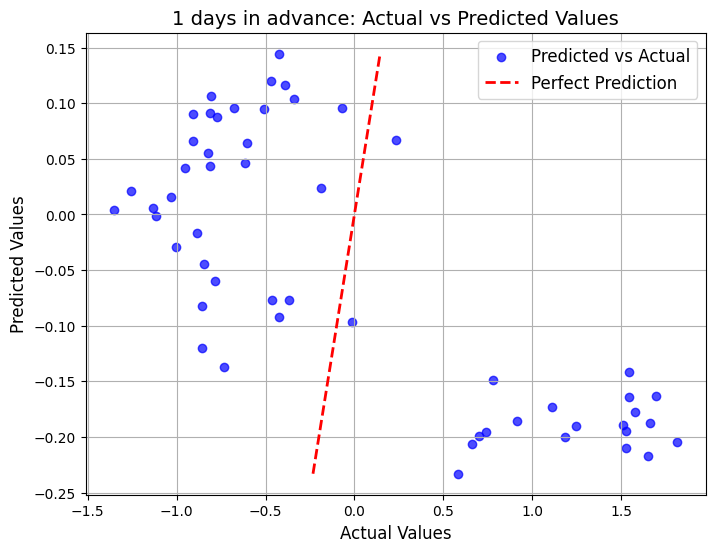

1 days in advance  MAE: 0.9776991268737918
1 days in advance  RMSE: 1.0945456088489394


In [12]:
for i in range(PREDICTED_DAYS):
    graph_predictions(predictions[:, i], Y_scaled[:, i], f'{i + 1} days in advance')
